In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../../../XRaySimulation2")

from XRaySimulation import util

In [19]:
def get_reflectivity(rock_th_scan,
                     g_vec_c,
                     n_vec_c,
                     t_vec_c,
                     kin_vec_c,
                     g_angle_fwhm=np.deg2rad(3e-3), g_angle_num=16,
                     phonon_q_fwhm=0, phonon_q_num=1,
                     x_energy_fwhm=0, x_energy_num=1,
                     x_angle_fwhm=0, x_angle_num=1,
                     crystal_property=None):
    rock_th_num = rock_th_scan.shape[0]
    total_entry_num = g_angle_num * phonon_q_num * x_angle_num * x_energy_num * rock_th_num

    x_energy_sigma = util.intensity_fwhm_to_field_sigma(fwhm=x_energy_fwhm)
    x_angle_sigma = util.intensity_fwhm_to_field_sigma(fwhm=x_angle_fwhm)
    phonon_q_sigma = util.intensity_fwhm_to_field_sigma(fwhm=phonon_q_fwhm)
    g_angle_sigma = util.intensity_fwhm_to_field_sigma(fwhm=g_angle_fwhm)

    # Create holder and assign the central value
    k_array = np.reshape(np.outer(np.ones(total_entry_num), kin_vec_c),
                         newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num, 3))
    g_array = np.reshape(np.outer(np.ones(total_entry_num), g_vec_c),
                         newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num, 3))
    n_array = np.reshape(np.outer(np.ones(total_entry_num), n_vec_c),
                         newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num, 3))
    phonon_q_array = np.reshape(np.outer(np.ones(total_entry_num), t_vec_c),
                                newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num, 3))
    phonon_p_array = np.reshape(np.outer(np.ones(total_entry_num), t_vec_c / np.linalg.norm(t_vec_c)),
                                newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num, 3))
    phonon_omega_array = np.ones((g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num),
                                 dtype=np.float64) * 0.75e-3  # 0.5 THz phonon

    # Assign the scan value
    if x_energy_num > 1:
        x_energy_scan = np.linspace(start=-x_energy_fwhm * 2., stop=x_energy_fwhm * 2., num=x_energy_num)
        x_energy_field = (np.exp(- x_energy_scan ** 2 / 2. / x_energy_sigma ** 2) /
                          np.power(np.pi * x_energy_sigma ** 2, 0.25))
        scaling = util.kev_to_wavevec_length(x_energy_scan) / np.linalg.norm(kin_vec_c) + 1
        k_array *= scaling[np.newaxis, np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

    if x_angle_num > 1:
        x_angle_scan = np.linspace(start=-x_angle_fwhm * 2., stop=x_angle_fwhm * 2., num=x_angle_num)
        x_angle_field = (np.exp(- x_angle_scan ** 2 / 2. / x_angle_sigma ** 2) /
                         np.power(np.pi * x_angle_sigma ** 2, 0.25))
        for idx in range(x_angle_num):
            diverg_mat = util.get_rotmat_around_axis(angleRadian=x_angle_scan[idx],
                                                     axis=np.array([-1., 1., 0.]) / np.sqrt(2))
            k_array[:, :, idx, :, :, :] = np.dot(k_array[:, :, idx, :, :, :], diverg_mat.T)

    if phonon_q_num > 1:
        phonon_q_scan = np.linspace(start=-phonon_q_fwhm * 2., stop=phonon_q_fwhm * 2., num=phonon_q_num)
        phonon_field = (np.exp(- phonon_q_scan ** 2 / 2. / phonon_q_sigma ** 2) /
                        np.power(np.pi * phonon_q_sigma ** 2, 0.25))
        # phonon_field /= np.max(phonon_field) 
        # phonon_field *= 1e-3
        phonon_field *= np.sqrt(1e-3)

        phonon_q_array[:, :, :, :, :, 0] += phonon_q_scan[np.newaxis, :, np.newaxis, np.newaxis, np.newaxis]
        phonon_p_array[:, :, :, :, :, 0] *= phonon_field[np.newaxis, :, np.newaxis, np.newaxis, np.newaxis]
        phonon_p_array[:, :, :, :, :, 0] *= phonon_q_scan[1] - phonon_q_scan[0]

        #return phonon_field
        print("With this phonon field, the maximal displacement is {} nm".format(
            1000 * np.sum(phonon_field) * (phonon_q_scan[1] - phonon_q_scan[0])))
        print("With this phonon field, the STD displacement is {} nm".format(
            1000 * np.sum(phonon_field ** 2) * (phonon_q_scan[1] - phonon_q_scan[0])))

    if g_angle_num > 1:
        g_angle_scan = np.linspace(start=-g_angle_fwhm * 2., stop=g_angle_fwhm * 2., num=g_angle_num)
        g_angle_field = (np.exp(- g_angle_scan ** 2 / 2. / g_angle_sigma ** 2) /
                         np.power(np.pi * g_angle_sigma ** 2, 0.25))
        for idx in range(g_angle_num):
            diverg_mat = util.get_rotmat_around_axis(angleRadian=g_angle_scan[idx],
                                                     axis=np.array([-1., 1., 0.]) / np.sqrt(2))
            g_array[idx, :, :, :, :, :] = np.dot(g_array[idx, :, :, :, :, :], diverg_mat.T)

    #print(g_array)

    # scan the sample rotation 
    tilt_angle = np.deg2rad(11.5)
    tilt_mat = util.get_rotmat_around_axis(angleRadian=tilt_angle, axis=np.array([0, 1., 0.]))

    for idx in range(rock_th_scan.shape[0]):
        rot_mat = util.get_rotmat_around_axis(angleRadian=rock_th_scan[idx], axis=np.array([1., 0., 0.]))
        g_array[:, :, :, :, idx, :] = np.dot(np.dot(g_array[:, :, :, :, idx, :], rot_mat.T), tilt_mat.T)
    # Calculate the reflectivity
    (R0H, R00, b,
     d_plus, d_minus,
     kout, delta_chih) = util.get_bragg_reflectivity_with_phonon(
        kVec=np.reshape(k_array, newshape=(total_entry_num, 3)),
        thickness=500.,  # um
        BraggG=np.reshape(g_array, newshape=(total_entry_num, 3)),
        normal=np.reshape(n_array, newshape=(total_entry_num, 3)),
        phononQ=np.reshape(phonon_q_array, newshape=(total_entry_num, 3)),
        omega=np.reshape(phonon_omega_array, newshape=total_entry_num),
        polar=np.reshape(phonon_p_array, newshape=(total_entry_num, 3)),
        chi0=crystal_property['chi0'],
        chih=crystal_property['chih'],
        chihbar=crystal_property['chih'], )

    # Get the averaged quantity as a function of rocking th
    reflectivity_plus = np.reshape(np.copy(d_plus),
                                   newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num))
    reflectivity_minus = np.reshape(np.copy(d_minus),
                                    newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num))
    reflectivity = np.reshape(np.copy(R0H),
                              newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num))
    b = np.reshape(b, newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num))

    # delta_chih = np.reshape(delta_chih, newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num))
    # kout = np.reshape(kout, newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num, 3))

    # Average over each level:
    if phonon_q_num > 1:  # Remove the phonon q dependence since this is a coherent contribution
        reflectivity = np.sum(reflectivity, axis=1) / phonon_q_num
        reflectivity_plus = np.sum(reflectivity_plus, axis=1)
        reflectivity_minus = np.sum(reflectivity_minus, axis=1)
        b = np.sum(b, axis=1)
        

    if g_angle_num > 1:
        reflectivity = (np.multiply(
            reflectivity,
            g_angle_field[:, np.newaxis, np.newaxis, np.newaxis].astype(np.complex128))
                        * np.sqrt(g_angle_scan[1] - g_angle_scan[0]))
        reflectivity_plus = (np.multiply(
            reflectivity_plus,
            g_angle_field[:, np.newaxis, np.newaxis, np.newaxis].astype(np.complex128))
                             * np.sqrt(g_angle_scan[1] - g_angle_scan[0]))
        reflectivity_minus = (np.multiply(
            reflectivity_minus,
            g_angle_field[:, np.newaxis, np.newaxis, np.newaxis].astype(np.complex128))
                              * np.sqrt(g_angle_scan[1] - g_angle_scan[0]))

    if x_energy_num > 1:
        reflectivity = (np.multiply(
            reflectivity,
            x_energy_field[np.newaxis, np.newaxis, :, np.newaxis].astype(np.complex128))
                        * np.sqrt(x_energy_scan[1] - x_energy_scan[0]))
        reflectivity_plus = (np.multiply(
            reflectivity_plus,
            x_energy_field[np.newaxis, np.newaxis, :, np.newaxis].astype(np.complex128))
                             * np.sqrt(x_energy_scan[1] - x_energy_scan[0]))
        reflectivity_minus = (np.multiply(
            reflectivity_minus,
            x_energy_field[np.newaxis, np.newaxis, :, np.newaxis].astype(np.complex128))
                              * np.sqrt(x_energy_scan[1] - x_energy_scan[0]))
    if x_angle_num > 1:
        reflectivity = (np.multiply(
            reflectivity,
            x_angle_field[np.newaxis, :, np.newaxis, np.newaxis].astype(np.complex128))
                        * np.sqrt(x_angle_scan[1] - x_angle_scan[0]))
        reflectivity_plus = (np.multiply(
            reflectivity_plus,
            x_angle_field[np.newaxis, :, np.newaxis, np.newaxis].astype(np.complex128))
                             * np.sqrt(x_angle_scan[1] - x_angle_scan[0]))
        reflectivity_minus = (np.multiply(
            reflectivity_minus,
            x_angle_field[np.newaxis, :, np.newaxis, np.newaxis].astype(np.complex128))
                              * np.sqrt(x_angle_scan[1] - x_angle_scan[0]))

    # Perform the averaging calculation
    #reflectivity = np.sum(np.square(np.abs(reflectivity)) / np.abs(b), axis=-1)
    #reflectivity_plus = np.sum(np.square(np.abs(reflectivity_plus)) / np.abs(b), axis=-1)
    #reflectivity_minus = np.sum(np.square(np.abs(reflectivity_minus)) / np.abs(b), axis=-1)

    reflectivity_total = np.sum(np.square(np.abs(reflectivity
                                                 + reflectivity_plus + reflectivity_minus)) / np.abs(b),
                                axis=(0, 1, 2))
    reflectivity_tg = np.sum(np.square(np.abs(reflectivity_plus + reflectivity_minus)) / np.abs(b),
                             axis=(0, 1, 2))

    return reflectivity_total, reflectivity_tg


In [20]:
Ec = 9.8  # keV
klen = util.kev_to_wavevec_length(Ec)

# Get the k_in
wedge_angle = np.deg2rad(10)
rot_mat = util.get_rotmat_around_axis(angleRadian=np.deg2rad(3.575 * 2),
                                      axis=np.array([0, np.sin(wedge_angle), -np.cos(wedge_angle)]))
si111_angle = np.deg2rad(2 * 11.639 - 0.2)
k_vec = np.dot(rot_mat, np.array([0, - np.sin(si111_angle), np.cos(si111_angle), ]) * klen)

# Get the STO 220 crystal property
crystal_property = {"d": 1.3806 * 1e-4,  # um
                    "chi0": complex(-0.20135E-04, 0.63853E-06),
                    "chih": complex(0.10376E-04, -0.60756E-06),
                    "chih_pi": complex(0.60195E-05, -0.35235E-06), }

# Get the reciprocal lattice
tilt_angle = np.deg2rad(11.5)
tilt_mat = util.get_rotmat_around_axis(angleRadian=tilt_angle, axis=np.array([0, 1., 0.]))

#g_vec = np.dot(tilt_mat, np.array([1, 1, 0]) / np.sqrt(2) * np.pi * 2 / crystal_property['d'])
g_vec = np.array([1, 1, 0]) / np.sqrt(2) * np.pi * 2 / crystal_property['d']

# Get the crystal normal direction
normal_vec = np.array([- np.cos(tilt_angle), 0, np.sin(tilt_angle)])

# Get the TG vector
tg_angle = np.deg2rad(0.1567 * 2 - 7e-3)
t_vec = np.array([1, 0, 0]) * klen * np.sin(tg_angle) * 2.

# Quick demonstration of all peaks

With this phonon field, the maximal displacement is 0.6177939219126151 nm
With this phonon field, the STD displacement is 1.8789318961003953 nm


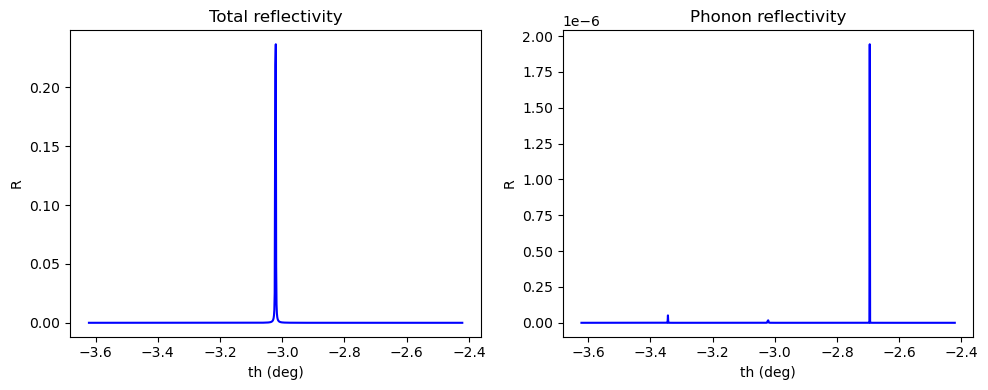

In [21]:
# Span the angle and energy range
num = 2 ** 10  # Number of points to calculate
rock_angle = np.linspace(start=np.deg2rad(-3.0213 - 0.6), stop=np.deg2rad(-3.0213 + 0.6), num=num)

reflectivity_tot, reflectivity_phonon = get_reflectivity(rock_th_scan=rock_angle,
                                                         g_vec_c=np.copy(g_vec),
                                                         n_vec_c=np.copy(normal_vec),
                                                         t_vec_c=np.copy(t_vec),
                                                         kin_vec_c=np.copy(k_vec),
                                                         g_angle_fwhm=np.deg2rad(3e-6),
                                                         g_angle_num=4,
                                                         phonon_q_fwhm=1e-4,
                                                         phonon_q_num=3,
                                                         x_energy_fwhm=1e-6,
                                                         x_energy_num=6,
                                                         x_angle_fwhm=1e-6,
                                                         x_angle_num=5,
                                                         crystal_property=crystal_property)

fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(4)

axes[0].plot(np.rad2deg(rock_angle), reflectivity_tot, color='b', linestyle="-")
axes[0].set_title("Total reflectivity")
axes[0].set_ylabel("R")
axes[0].set_xlabel("th (deg)")

axes[1].plot(np.rad2deg(rock_angle), reflectivity_phonon, color='b', linestyle="-")
axes[1].set_title("Phonon reflectivity")
axes[1].set_ylabel("R")
axes[1].set_xlabel("th (deg)")

plt.tight_layout()
plt.show()

# Get the central Bragg peak

With this phonon field, the maximal displacement is 84.83979311789865 nm
With this phonon field, the STD displacement is 0.9999996643270714 nm


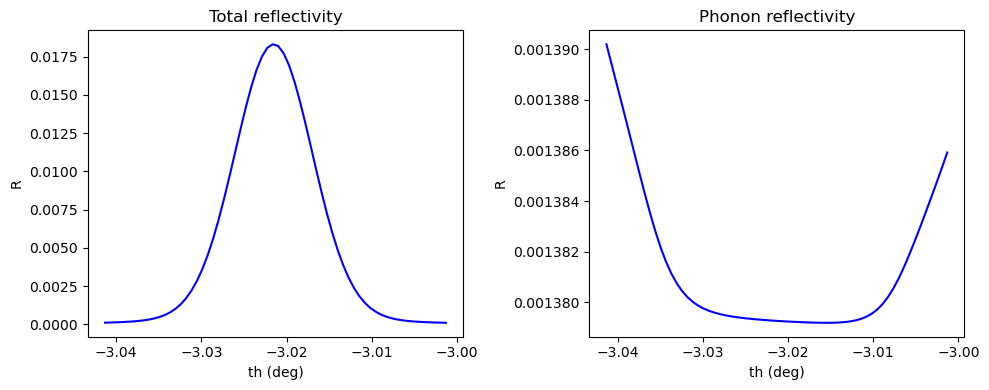

In [22]:
# Span the angle and energy range
num = 2 ** 6  # Number of points to calculate
rock_angle = np.linspace(start=np.deg2rad(-3.0213 - 0.02), stop=np.deg2rad(-3.0213 + 0.02), num=num)

reflectivity_tot, reflectivity_phonon = get_reflectivity(rock_th_scan=rock_angle,
                                                         g_vec_c=np.copy(g_vec),
                                                         n_vec_c=np.copy(normal_vec),
                                                         t_vec_c=np.copy(t_vec),
                                                         kin_vec_c=np.copy(k_vec),
                                                         g_angle_fwhm=np.deg2rad(7e-3),
                                                         g_angle_num=32,
                                                         phonon_q_fwhm=t_vec[0] / 157,
                                                         phonon_q_num=16,
                                                         x_energy_fwhm=0.3e-3,
                                                         x_energy_num=16,
                                                         x_angle_fwhm=14e-6,
                                                         x_angle_num=16,
                                                         crystal_property=crystal_property)

fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(4)

axes[0].plot(np.rad2deg(rock_angle), reflectivity_tot, color='b', linestyle="-")
axes[0].set_title("Total reflectivity")
axes[0].set_ylabel("R")
axes[0].set_xlabel("th (deg)")

axes[1].plot(np.rad2deg(rock_angle), reflectivity_phonon / (reflectivity_tot - reflectivity_phonon), color='b',
             linestyle="-")
axes[1].set_title("Phonon reflectivity")
axes[1].set_ylabel("R")
axes[1].set_xlabel("th (deg)")

plt.tight_layout()
plt.show()

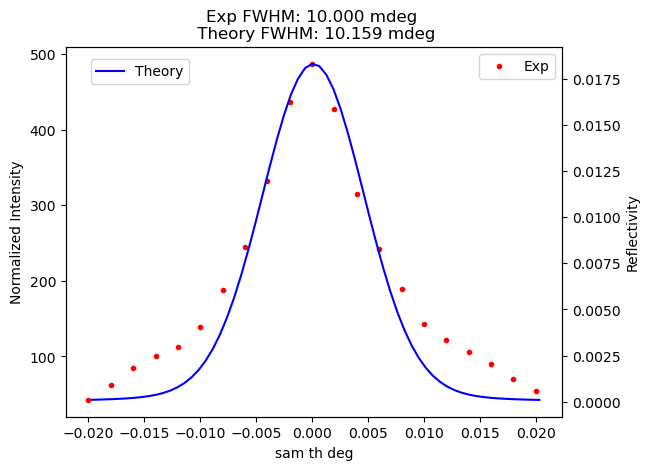

In [23]:
exp_intensity = np.load('./rocking_sto220.npy')[0]
sam_th = np.load('./sam_th_sto220.npy')

sam_th -= sam_th[np.argmax(exp_intensity)]

fwhm_exp = util.get_fwhm(coordinate=sam_th, curve_values=exp_intensity)
fwhm_theory = util.get_fwhm(coordinate=np.rad2deg(rock_angle), curve_values=reflectivity_tot)

# ------------------------------------------
fig, axes = plt.subplots(ncols=1, nrows=1)
axes.plot(sam_th, exp_intensity, marker='.', linestyle='', color='r', label='Exp')
axes.set_ylabel('Normalized Intensity')
axes.set_xlabel("sam th deg")
axes.set_title("Exp FWHM: {:.3f} mdeg \n Theory FWHM: {:.3f} mdeg".format(fwhm_exp * 1000, fwhm_theory * 1000))
axes.legend()

axes_twin = axes.twinx()
axes_twin.plot(np.rad2deg(rock_angle - rock_angle[np.argmax(reflectivity_tot)]),
               reflectivity_tot, color='b', label='Theory')
axes_twin.legend(loc=(0.05, 0.9))
axes_twin.set_ylabel('Reflectivity')

plt.show()

With this phonon field, the maximal displacement is 84.82020996443177 nm
With this phonon field, the STD displacement is 0.9999989395511272 nm


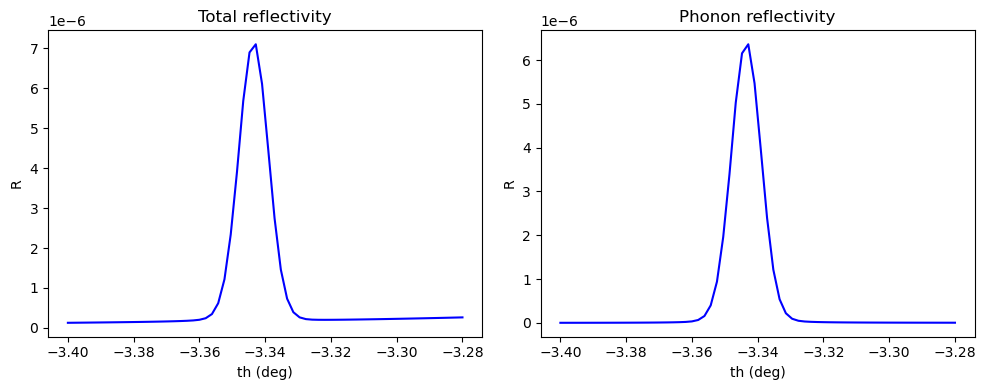

In [24]:
# Span the angle and energy range
num = 2 ** 6  # Number of points to calculate
rock_angle = np.linspace(start=np.deg2rad(-3.4), stop=np.deg2rad(-3.28), num=num)

reflectivity_tot, reflectivity_phonon = get_reflectivity(rock_th_scan=rock_angle,
                                                         g_vec_c=np.copy(g_vec),
                                                         n_vec_c=np.copy(normal_vec),
                                                         t_vec_c=np.copy(t_vec),
                                                         kin_vec_c=np.copy(k_vec),
                                                         g_angle_fwhm=np.deg2rad(7e-3),
                                                         g_angle_num=32,
                                                         phonon_q_fwhm=t_vec[0] / 157,
                                                         phonon_q_num=32,
                                                         x_energy_fwhm=0.3e-3,
                                                         x_energy_num=16,
                                                         x_angle_fwhm=14e-6,
                                                         x_angle_num=16,
                                                         crystal_property=crystal_property)

fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(4)

axes[0].plot(np.rad2deg(rock_angle), reflectivity_tot, color='b', linestyle="-")
axes[0].set_title("Total reflectivity")
axes[0].set_ylabel("R")
axes[0].set_xlabel("th (deg)")

axes[1].plot(np.rad2deg(rock_angle), reflectivity_phonon, color='b', linestyle="-")
axes[1].set_title("Phonon reflectivity")
axes[1].set_ylabel("R")
axes[1].set_xlabel("th (deg)")

plt.tight_layout()
plt.show()

The FWHM from gaussian fit is 0.013049692401656066


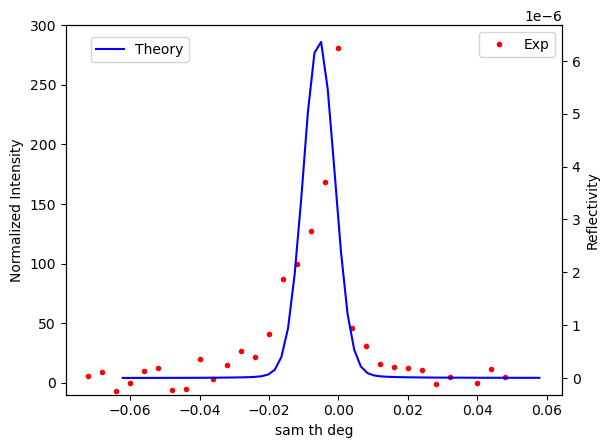

In [31]:
exp_intensity = np.load("12nm_rocking_I.npy")
exp_intensity_tmp = np.copy(exp_intensity)
exp_intensity_tmp[exp_intensity < 50] = 0

sam_th = np.load("12nm_rocking_theta.npy")

sam_th -= sam_th[np.argmax(exp_intensity)]

fwhm_exp = util.get_fwhm(coordinate=sam_th, curve_values=exp_intensity)
fwhm_theory = util.get_fwhm(coordinate=np.rad2deg(rock_angle), curve_values=reflectivity_phonon)

# Get the sigma
g_fit, std = util.get_gaussian_fit(coordinate=np.array(sam_th), curve=exp_intensity_tmp)
print("The FWHM from gaussian fit is {}".format(util.sigma_to_fwhm(std)))

# ------------------------------------------
fig, axes = plt.subplots(ncols=1, nrows=1)
axes.plot(sam_th, exp_intensity, marker='.', linestyle='', color='r', label='Exp')
#axes.plot(sam_th, g_fit, marker='.', linestyle='--', color='r', label='Exp - fit')
axes.set_ylabel('Normalized Intensity')
axes.set_xlabel("sam th deg")
#axes.set_title("Exp FWHM: {:.3f} mdeg \n Theory FWHM: {:.3f} mdeg".format(util.sigma_to_fwhm(std) * 1000, fwhm_theory * 1000))
axes.legend()
axes.set_ylim([-10, 300])

axes_twin = axes.twinx()
axes_twin.plot(np.rad2deg(rock_angle - rock_angle[np.argmax(reflectivity_phonon)]) - 0.005,
               reflectivity_phonon, color='b', marker='', linestyle='-', label='Theory')
axes_twin.legend(loc=(0.05, 0.9))
axes_twin.set_ylabel('Reflectivity')

plt.show()